# Imports et configuration

In [76]:
import pandas as pd
import sys
from pathlib import Path
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


project_root = Path.cwd().parent  # notebook/ → P12_systeme_reco_agriculture/
sys.path.insert(0, str(project_root))  # Dit à Python : "Cherche aussi ici !"

from config.paths import DONNEES_HISTORIQUES, DONNEES_AGRO_CLIMATIQUES
from config.config import RANDOM_STATE

# Chargement et Vue d'ensemble

## Chargement

In [77]:
df_historiques = pd.read_csv(DONNEES_HISTORIQUES / "crop_yield.csv")

In [78]:
df_historiques.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


## Informations générales

In [79]:
df_historiques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [80]:
df_historiques.shape

(1000000, 10)

In [81]:
df_historiques.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


## Valeurs manquantes 

In [82]:
df_historiques.isnull().sum()

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

<Axes: >

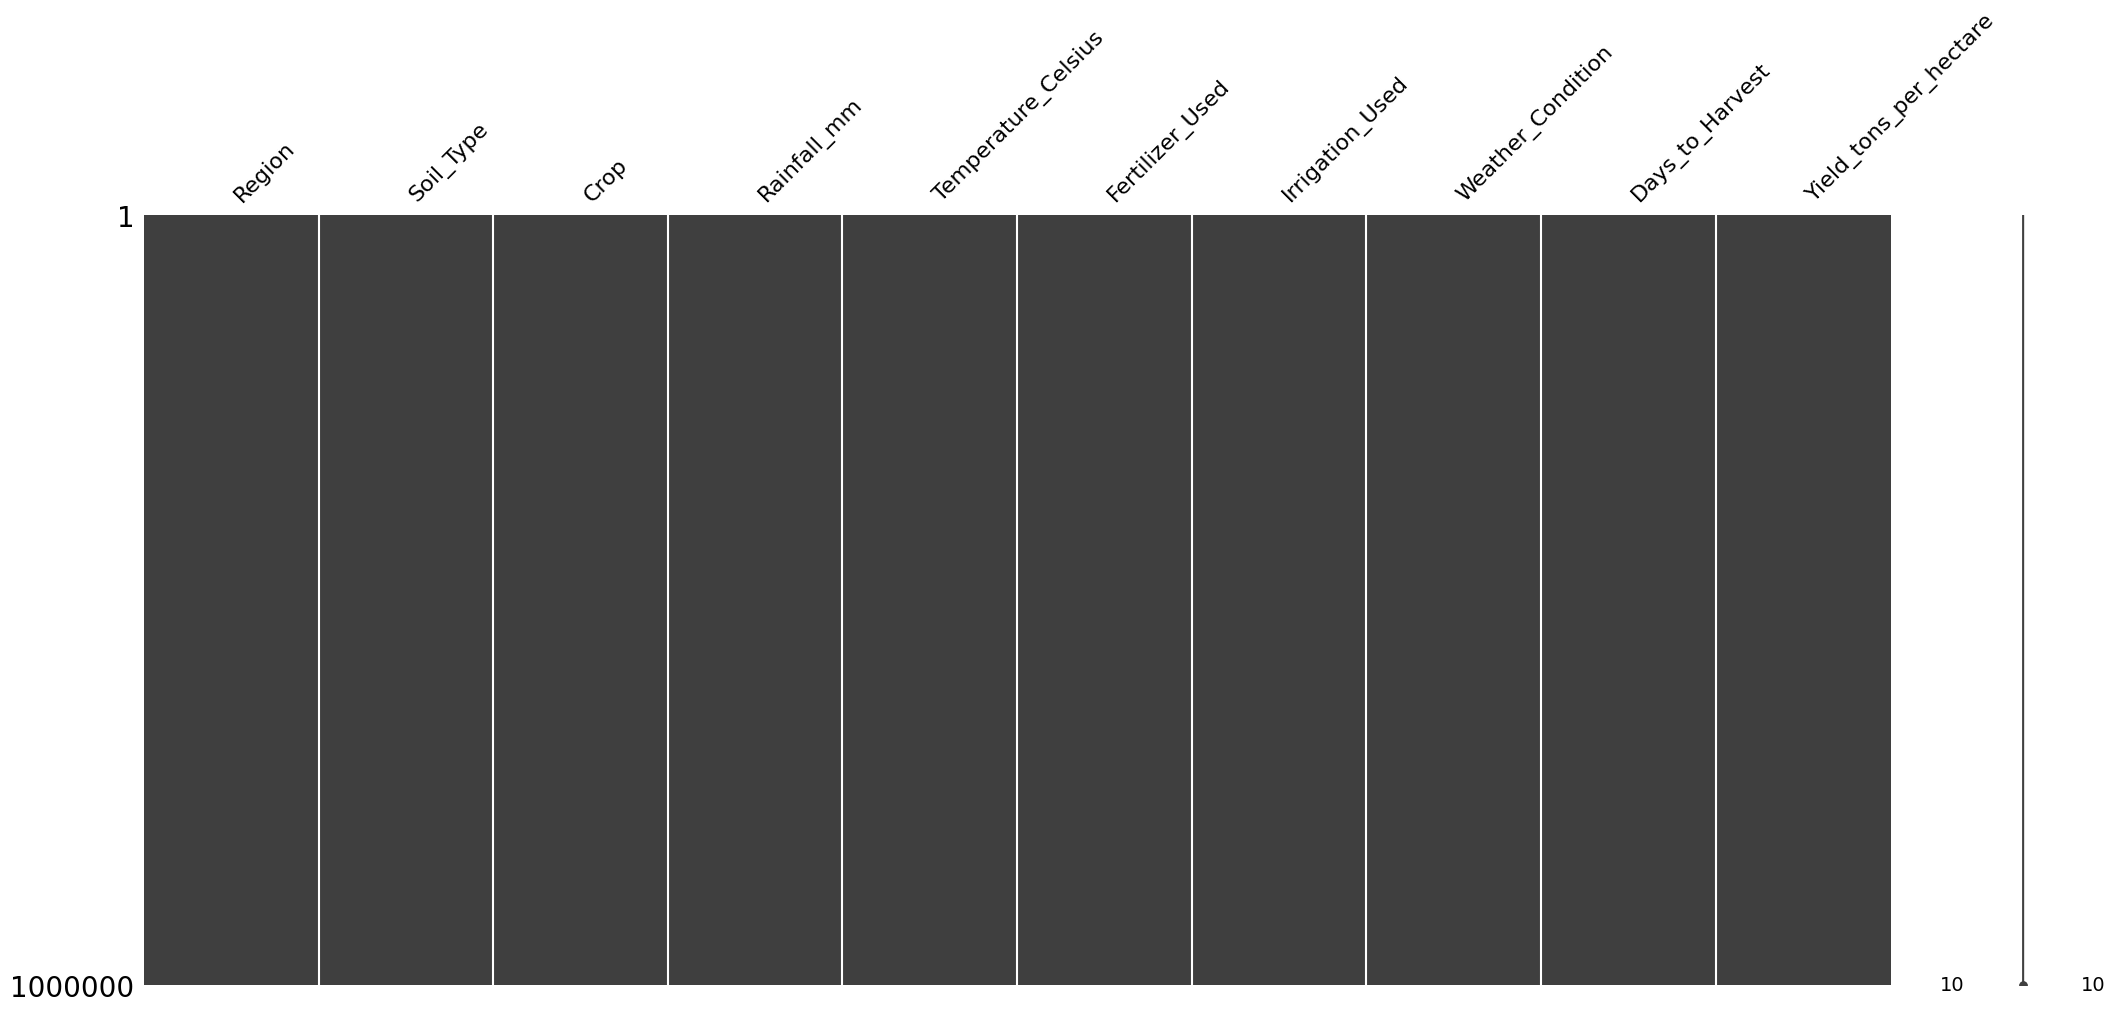

In [83]:
msno.matrix(df_historiques)

**Conclusion** : Aucune valeur manquante

# Nettoyage de la Variable Cible

## Analyse globale Yield_tons_per_hectare

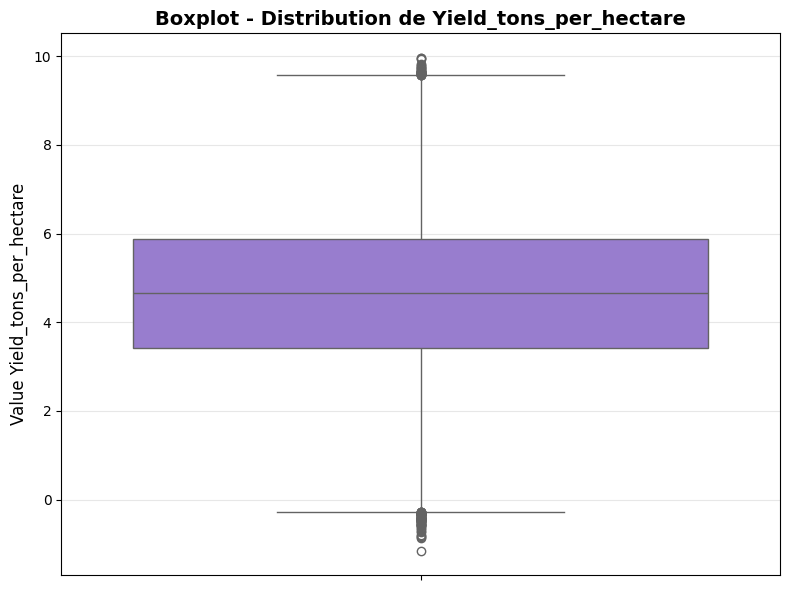


ANALYSE DES OUTLIERS
Q1 (25%) : 3.42
Q3 (75%) : 5.88
IQR : 2.46
Limite basse outliers : -0.27
Limite haute outliers : 9.57
Nombre d'outliers : 84 (0.01%)


In [84]:
# Créer le boxplot vertical
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_historiques['Yield_tons_per_hectare'], color='mediumpurple')
plt.ylabel('Value Yield_tons_per_hectare', fontsize=12)
plt.title('Boxplot - Distribution de Yield_tons_per_hectare', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques sur les outliers
Q1 = df_historiques['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df_historiques['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1
outlier_low = Q1 - 1.5 * IQR
outlier_high = Q3 + 1.5 * IQR

nb_outliers = ((df_historiques['Yield_tons_per_hectare'] < outlier_low) | 
               (df_historiques['Yield_tons_per_hectare'] > outlier_high)).sum()

print(f"\n{'='*50}")
print(f"ANALYSE DES OUTLIERS")
print(f"{'='*50}")
print(f"Q1 (25%) : {Q1:.2f}")
print(f"Q3 (75%) : {Q3:.2f}")
print(f"IQR : {IQR:.2f}")
print(f"Limite basse outliers : {outlier_low:.2f}")
print(f"Limite haute outliers : {outlier_high:.2f}")
print(f"Nombre d'outliers : {nb_outliers} ({nb_outliers/len(df_historiques)*100:.2f}%)")

Il y a visiblement des Outliers. A ce stade, on ne va supprimer que les valeurs négatives qui n'ont pas de sens et vérifier le rendement par type de culture pour les valeurs qui paraissent sur-dimensionnées.

## Suppression des valeurs négatives 

In [85]:
df_historiques = df_historiques.drop(df_historiques[df_historiques['Yield_tons_per_hectare'] < 0].index)

In [86]:
# Vérification après suppression
df_historiques.shape

(999769, 10)

## Analyse par culture

<Axes: xlabel='Crop', ylabel='Yield_tons_per_hectare'>

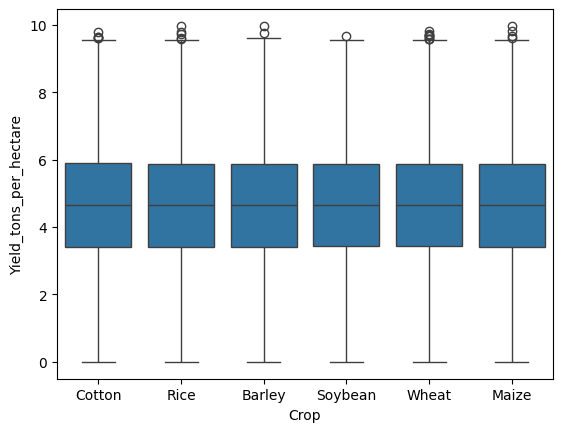

In [87]:
sns.boxplot(data=df_historiques, x='Crop', y='Yield_tons_per_hectare')

La distribution est similaire entre cultures. On voit que les valeurs hautes sont bien des outliers, quelque soit le type de culture. On va donc les supprimer

## Suppression outliers hauts

In [88]:
df_historiques = df_historiques.drop(df_historiques[df_historiques['Yield_tons_per_hectare'] > 9.50].index)

In [89]:
# Vérification après suppression
df_historiques.shape

(999708, 10)

<Axes: xlabel='Crop', ylabel='Yield_tons_per_hectare'>

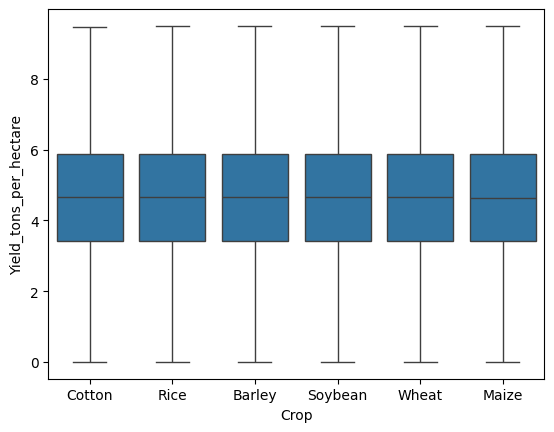

In [90]:
# Vérification boxplot
sns.boxplot(data=df_historiques, x='Crop', y='Yield_tons_per_hectare')

#  Analyse des variables catégorielles

## Region

In [91]:
df_historiques['Region'].value_counts()

Region
North    250099
West     249995
South    249984
East     249630
Name: count, dtype: int64

Quatre régions qui sont en réalité les 4 points cardinaux. Distribution homogène. Colonne qui sera probablement à supprimer car un point cardinal est forcément relatif par rapport à la zone géographique du futur utilisateur. On va vérifier avant si cette information a un impact sur la cible.

<Axes: xlabel='Region', ylabel='Yield_tons_per_hectare'>

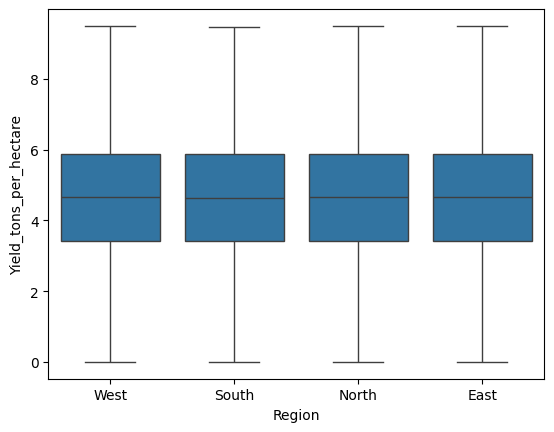

In [92]:
sns.boxplot(data=df_historiques, x='Region', y='Yield_tons_per_hectare')

**Conclusion** : aucun impact, boxplot complètement uniforme qui ne nous apprend rien. A supprimer

In [93]:
# Suppression de la colonne Region
df_historiques = df_historiques.drop(columns='Region')

In [94]:
# Vérification
df_historiques.shape

(999708, 9)

## Soil_type

In [95]:
df_historiques['Soil_Type'].value_counts()

Soil_Type
Sandy     167070
Loam      166751
Chalky    166717
Silt      166626
Clay      166300
Peaty     166244
Name: count, dtype: int64

Distribution homogène. 

<Axes: xlabel='Soil_Type', ylabel='Yield_tons_per_hectare'>

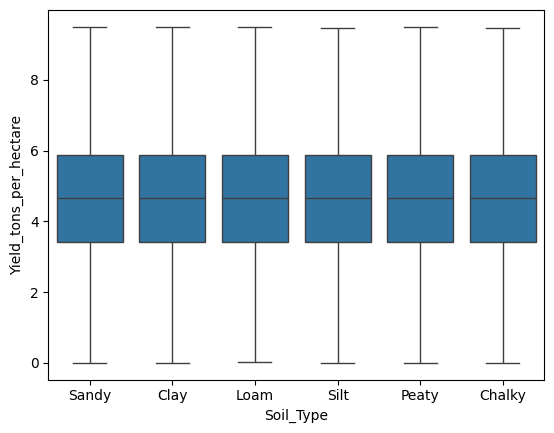

In [96]:
sns.boxplot(data=df_historiques, x='Soil_Type', y='Yield_tons_per_hectare')

**Conclusion** : aucun impact, boxplot complètement uniforme qui ne nous apprend rien. A supprimer

In [99]:
# Suppression de la colonne Region
df_historiques = df_historiques.drop(columns='Soil_Type')

In [100]:
# Vérification
df_historiques.shape

(999708, 8)

## Crop

In [41]:
df_historiques['Crop'].value_counts()

Crop
Maize      166785
Rice       166754
Barley     166727
Wheat      166640
Cotton     166548
Soybean    166315
Name: count, dtype: int64

<Axes: xlabel='Crop', ylabel='Yield_tons_per_hectare'>

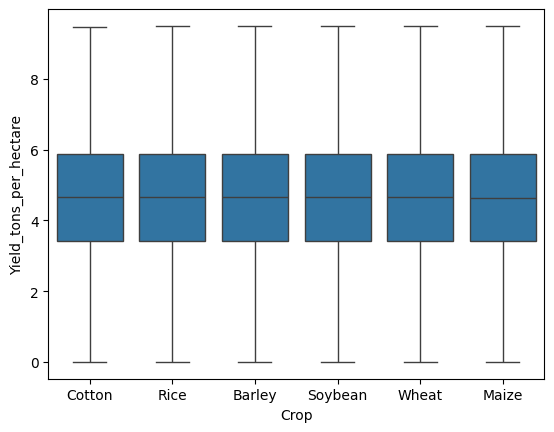

In [101]:
sns.boxplot(data=df_historiques, x='Crop', y='Yield_tons_per_hectare')

**Conclusion** : distribution homogène mais cette variable reste essentielle pour la segmentation, on va donc la conserver

## Weather_Condition 

<Axes: xlabel='Weather_Condition', ylabel='Yield_tons_per_hectare'>

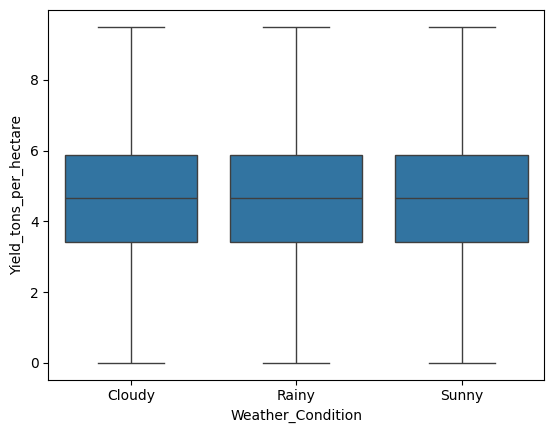

In [59]:
sns.boxplot(data=df_historiques, x='Weather_Condition', y='Yield_tons_per_hectare')

**Conclusion** : aucun impact, boxplot complètement uniforme qui ne nous apprend rien. A supprimer

In [102]:
# Suppression de la colonne Region
df_historiques = df_historiques.drop(columns='Weather_Condition')

In [103]:
# Vérification
df_historiques.shape

(999708, 7)

# Analyse des valeurs booléennes 

## Fertilizer_Used 

<Axes: xlabel='Fertilizer_Used', ylabel='Yield_tons_per_hectare'>

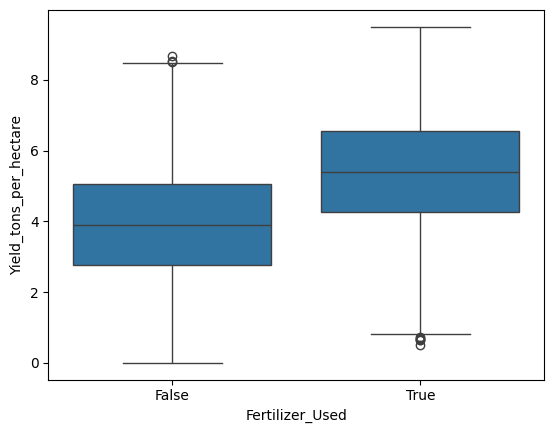

In [57]:
sns.boxplot(data=df_historiques, x='Fertilizer_Used', y='Yield_tons_per_hectare')

**IMPACT MAJEUR** visible (False: 4.0 t/ha, True: 6.5 t/ha = +60%) - **A conserver**

## Irrigation_Used

<Axes: xlabel='Irrigation_Used', ylabel='Yield_tons_per_hectare'>

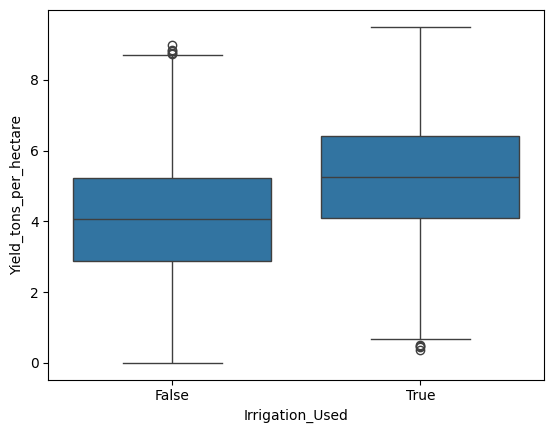

In [58]:
sns.boxplot(data=df_historiques, x='Irrigation_Used', y='Yield_tons_per_hectare')

**IMPACT MAJEUR** visible (False: 4.0 t/ha, True: 5.5 t/ha = +60%) - **A conserver**

# Analyse des variables numériques

## Corrélations

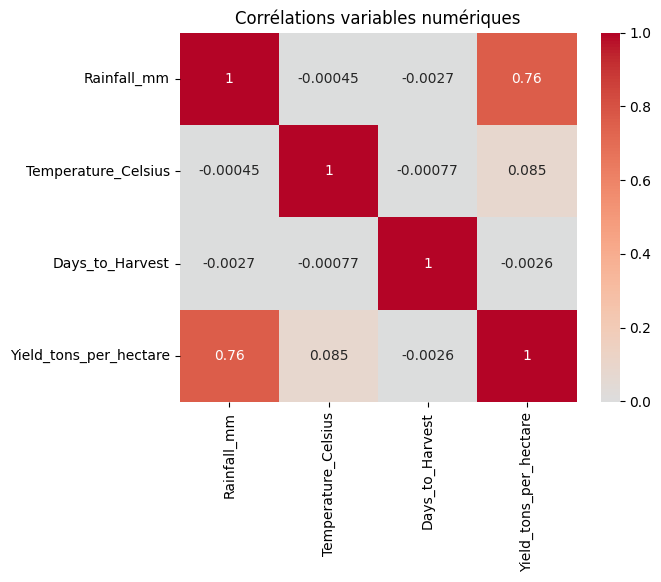

In [104]:
# Variables numériques vs cible SUR DATASET COMPLET
num_vars = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
correlations = df_historiques[num_vars + ['Yield_tons_per_hectare']].corr()

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations variables numériques')
plt.show()

**Résultats observés :**
- Temperature --> Yield : 0,09 (très faible)
- Days_to_Harvest --> Yield : 0,008 (quasi-nulle)
- Rainfall → Yield : 0,77 (FORTE)

**Interprétation**
- Rainfall est l'unique variable prédictive
- Temperature et Days_to_Harvest apportent juste des informations complémentaires et seront donc conservées.

# Dataset Final - Vue d'ensemble

In [109]:
print("=== DATASET NETTOYÉ - RÉSUMÉ ===")
print(f"Shape finale : {df_historiques.shape}")
print(f"\nNombre de lignes par culture :")
print(df_historiques['Crop'].value_counts())

=== DATASET NETTOYÉ - RÉSUMÉ ===
Shape finale : (999708, 7)

Nombre de lignes par culture :
Crop
Maize      166777
Rice       166746
Barley     166714
Wheat      166626
Cotton     166539
Soybean    166306
Name: count, dtype: int64


- Distribution homogène entre cultures (~166K lignes chacune)
- Rendements moyens similaires (~4.65 t/ha toutes cultures confondues)
- **Conclusion** : Ce dataset synthétique traite toutes les cultures de manière identique

# Sauvegarde 

In [108]:
output_path = DONNEES_HISTORIQUES / "crop_yield_clean.csv"
df_historiques.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_historiques.shape}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\agriculture_crop_yield\crop_yield_clean.csv
Shape final : (999708, 7)
